# Explore single experiment executions

We collect data from N runs processing M deployment changes moving the accounting node between Germany and the USA.

Initially, we read the (test) data frame containing values for
 * total time between incoming event (this should be also measuring time) and reconfiguration of probes
 * model update includes code to model level mapping and actual PCM model update
 * privacy update is the complete time necessary to recomupte the privacy properties
 * configuration time is the time used to take the privacy result, compute probe configuration and probe reconfiguration.
 
**Note:** This notebook is only used to explore and check the data for issues, e.g., prematurely terminated runs, extreme outliers which may indicate technical issues.

In [30]:
base <- "/data/reiner/jss-experiments/execution-2/"
experiment <- "simulated-account-services-100"

data <- ""

for (loop in 0:200) {
    measurementFile <- sprintf("%s/%s/%d/performance-results/execution-%d.csv", base, experiment, loop, loop)
    if (file.exists(measurementFile)) {
        if (file.size(measurementFile) > 0) {
            # print(sprintf("Reading %s ...", measurementFile))
            input <- read.csv(measurementFile)
            if (typeof(data) == "character") {
                data <- input
            } else {
                data <- rbind(data, input)
            }
        } else {
            print(sprintf("File %s is empty.", measurementFile))
        }
    }    
}

print(length(data[,1]))

[1] 42054


## Load plot libraries and define common R functions

In [31]:
library(ggplot2)
library(magrittr)
library(ggpubr)
library(repr)

plotFunc <- function(input, column, label, upperLimit, shape) {
    col <- input[,column]
    return (ggplot(input, aes (y=col, x="")) + geom_boxplot(outlier.shape = shape) + ylab("Time [ns]") + xlab(label) + ylim(0,upperLimit))
}

plotAll <- function(data, upperlimit, shape){
    plots <- list()

    i <- 1
    for (label in colnames(data)) {
        if ( i > 1 ) {
            label <- gsub("[.]", " ",label)
            plots[[i-1]] <- plotFunc(data,i,label,upperLimit, shape)
        }
        i <- i + 1
    }

    ggarrange(plotlist=plots, ncol = length(plots), nrow = 1)
}

options(repr.plot.height=3)

## Measurements

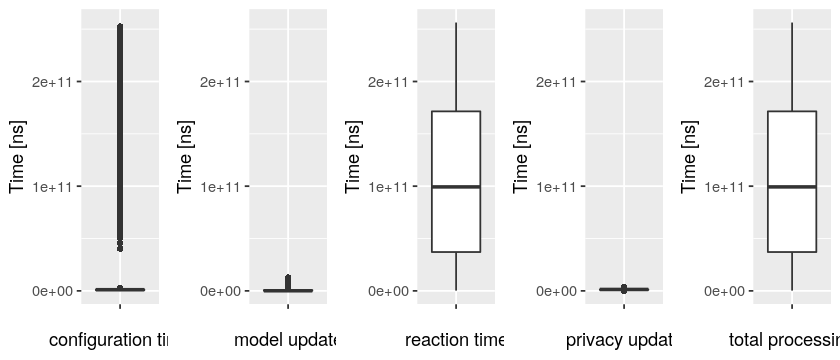

In [32]:
upperLimit <- max(data[,"total.processing"],data[,"reaction.time"],data[,"privacy.update"], data[,"model.update"], data[,"configuration.time"])

plotAll(data,upperLimit, 16)

## Measurements over Time

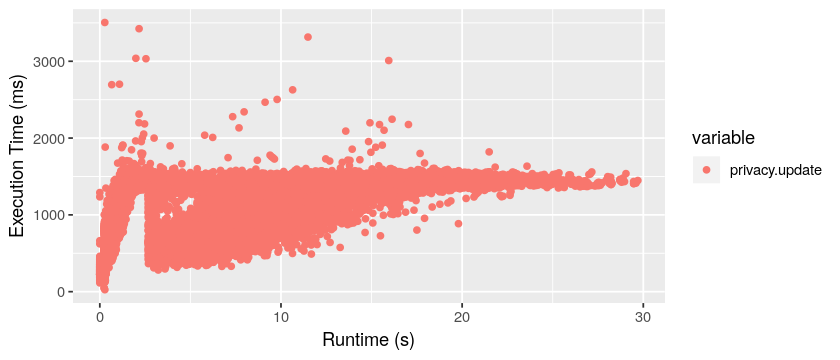

In [33]:
library(reshape2)

plotData <- data
plotData[,"date"] <- plotData[,"date"]/1000/1000/1000

allColumns <- colnames(data)
measureColumns <- allColumns[c(5)]
#length(allColumns)]

ggData <- melt(plotData, id.vars = "date", measure.vars = measureColumns)

ggData[,3] <- ggData[,3]/1000/1000 

ggplot(ggData, aes(x=date, y=value, linetype = variable, color = variable)) + geom_point() + xlab("Runtime (s)") + ylab("Execution Time (ms)")

## Measurements without depicting outliers

Warning message:
“Removed 822 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 6360 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 6360 rows containing non-finite values (stat_boxplot).”

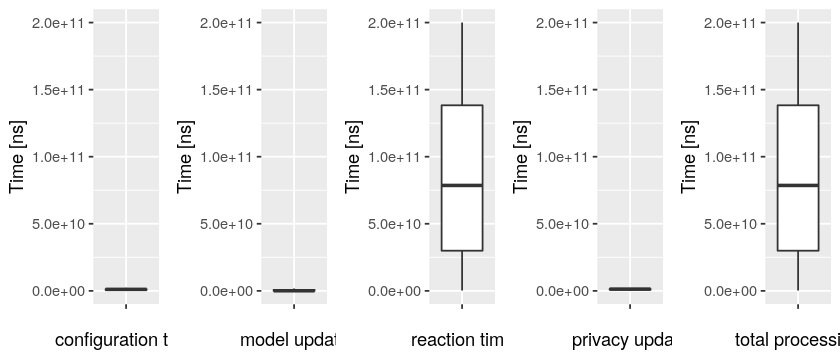

In [34]:
upperLimit <- 200000000000

plotAll(data, upperLimit, NA)

In [25]:
label.vals <- c()
mean.vals <- c()
median.vals <- c()
var.vals <- c()

unit.conversion <- 1000 * 1000

cleaned <- subset(data, !is.na(total.processing))

i <- 1
for (label in colnames(data)) {
    label.vals[[i]] <- gsub("[.]", " ",label)
    input <- cleaned[,i] / unit.conversion
    
    median.vals[[i]] <- median(input, na.rm=TRUE)
    mean.vals[[i]] <- mean(input, na.rm=TRUE)
    var.vals[[i]] <- var(input, na.rm=TRUE)
    i <- i + 1
}

result <- data.frame("measurement" = label.vals, "mean" = mean.vals, "median" = median.vals, "variance" = var.vals)

print(result)

         measurement         mean       median     variance
1               date  15014.84059  13499.72556 1.066961e+08
2 configuration time   8421.27941   8668.83725 1.299014e+07
3       model update     49.00781     39.91073 1.537680e+04
4      reaction time 115923.06011 112332.73653 3.972249e+09
5     privacy update    292.37566    281.64265 1.990158e+04
6   total processing 115923.04705 112332.73385 3.972250e+09


All values are in milli seconds.
* _Total processing_ time is the sum of _privacy update_ time and _model update_ time
* _Reaction time_ includes _configuration time_ and _total processing_ time. Still it is lower than _configuration time_ plus _total processing_ time, as the filters for _privacy update_, _model update_ and _configuration_ run in separate threads.